<a href="https://colab.research.google.com/github/Ne-oL/MLHydrogeochemisty/blob/main/SDG%20Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import pandas as pd
import random
import math
import copy
import geoz
import shap
import seaborn as sns
import geopandas as gpd
import matplotlib as mpl
from sklearn.inspection import DecisionBoundaryDisplay
from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC, SVR
import matplotlib.pyplot as plt
from sklearn import metrics
from pyproj import CRS
from pyproj import Transformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.kernel_approximation import Nystroem
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [4]:
# !pip install geoz


In [6]:
def bazel_cluster(X,y,n_samples=False, extent=1, random_seed=None):
    '''
    This Function Creates a Bazel round the study area, the defaults are robust but not gurateed to work.
    its pretty easy to check if the function worked or not by looking at the final map/Decision Boundary plot,
    if the map have a Bazel, it means the method didn't work and the user needs to adjust the default values to increase
    generated data points to force the model to consider the Bazel cluster as the background. if it works, the map will be
    clear, showing only the clusters of interest without the Bazel showing.

    Caution: This method have very specific usage to complement ONLY the SVM Classification algorithm by allowing all the
    clusters to show on the Map through forcing the SVM Classifier to consider the generated dummy data as the majority,
    thus acting as a background to the Decision Boundary plot which is a representation of the geographic map.

    X: Dataset containing only Longitude and Latitude (must be the only features used by the Classifier to create the final map).

    y: array or array-like containing only the predicted clusters names (Must be Numerical e.g. 1,2,3,4...).

    n_samples: this variable is generated based on your dataset, you only need to modify it if the method fails force
    SVM Classifier to consider the cluster as a background.

    extent: the "width" of the generated Bazel, there should be no need to change this variable, however, if the method
    failed after menipulating n_samples, you could try to increase the default to 3 or 4 while increase the n_samples
    accourdingly.

    '''

    # latExtra= (latlong.LATITUDE.max()-latlong.LATITUDE.min())*0.5
    # longExtra= (latlong.LONGITUDE.max()-latlong.LONGITUDE.min())*0.5

    random.seed(a=random_seed)

    latExtra= X.LATITUDE.std()*extent
    longExtra= X.LONGITUDE.std()*extent

    LlatMin= X.LATITUDE.min()-X.LATITUDE.std()
    LlatMax= X.LATITUDE.max()+X.LATITUDE.std()
    LlongMin= X.LONGITUDE.min()-X.LONGITUDE.std()
    LlongMax= X.LONGITUDE.max()+X.LONGITUDE.std()

    UlatMin= X.LATITUDE.min()-latExtra
    UlatMax= X.LATITUDE.max()+latExtra
    UlongMin= X.LONGITUDE.min()-longExtra
    UlongMax= X.LONGITUDE.max()+longExtra

    bottom=[[LlatMin,UlatMin],(UlongMin,UlongMax)]
    top=[[LlatMax,UlatMax],(UlongMin,UlongMax)]
    left=[[UlatMin,UlatMax],(UlongMin,LlongMin)]
    right=[[LlatMin,UlatMax],(LlongMax,UlongMax)]
    sides=[bottom, top, left, right]
    lat=[]
    long=[]

    if n_samples==False:
        n_samples=pd.Series(y).value_counts().values[0]

    for side in sides:
        for i in range(math.ceil(n_samples/4)):
            pointLat=random.uniform(side[0][0],side[0][1])
            pointLong=random.uniform(side[1][0],side[1][1])
            lat.append(pointLat)
            long.append(pointLong)
    dataset=pd.DataFrame({'LONGITUDE': long,'LATITUDE': lat})
    dataset['y']=np.array(y).max()+1
    Y=copy.deepcopy(y)
    Y.extend(dataset['y'].values)
    dataset=dataset[['LONGITUDE','LATITUDE']]
    X=pd.concat((X, dataset), axis=0,ignore_index= True)
    return X,Y


In [8]:
!ls

sample_data  temp.csv


In [64]:
rn=0 #Random number used across the code
data=pd.read_csv('temp.csv').set_index('Sample_Name')
data.rename(columns={'E':'LONGITUDE','N':'LATITUDE'},inplace=True)

latlong=data[['LATITUDE','LONGITUDE']]

data2= copy.deepcopy(data)
data2.drop(columns=['LONGITUDE','LATITUDE', 'Elevation (m)'], inplace=True)

scaler= StandardScaler()
data2S=pd.DataFrame(scaler.fit_transform(data2), index=data2.index, columns=data2.columns)

In [33]:
crs_latlong = CRS("EPSG:4326")            #WGS84 (Geographic Latitude & Longitude)
crs_proj = CRS('EPSG:32640')              #UTM (Projection UTM Zone 39/40)

transformer = Transformer.from_crs(crs_proj, crs_latlong)

latitudes, longitudes=transformer.transform(latlong['LONGITUDE'], latlong['LATITUDE'])
latlong.loc[:,'LONGITUDE'] = longitudes
latlong.loc[:,'LATITUDE']  = latitudes

<ipython-input-33-6491af900342>:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[55.75116207 55.74910886 55.75186709 55.7462632  55.73751525 55.73682189
 55.72230935 55.72095324 55.7084181  55.71401861 56.13141886 56.16124495
 56.20113635 56.24654407 56.27112738 56.32126608 56.08155204 56.10765251
 56.1359196  56.21899168 56.25059755 56.28719651 56.28559939 56.24021962
 56.20846686 56.03972017 56.03860633 56.02908056 56.04146353 56.04834573
 56.04808982 56.05353659 56.0878908  56.03639514 56.03454912 56.06189508
 56.05484024 56.06036258 56.06965015 56.06386168 56.07494516 56.09912525
 56.11402326 56.11857865 56.02998822]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  latlong.loc[:,'LONGITUDE'] = longitudes


In [34]:
#Imputation Process

clf=RandomForestRegressor(n_estimators=200, max_depth=6,n_jobs=40, random_state=0)
CLimputer= IterativeImputer(estimator= clf)
SOimputer= KNNImputer(n_neighbors=10, weights='distance')

data2S.loc['R-KH18','Cl-']=pd.DataFrame(CLimputer.fit_transform(data2S), index=data2.index, columns=data2.columns).loc['R-KH18','Cl-']
data2S.loc['R-KH18','SO42-']=pd.DataFrame(SOimputer.fit_transform(data2S), index=data2.index, columns=data2.columns).loc['R-KH18','SO42-']
data_fill = copy.deepcopy(data2S)
data_filled=data_fill.drop('Temperature (C°)', axis=1)

In [35]:
data_filled.to_csv('datascaled.csv')

<ipython-input-36-2959d74676c1>:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  clustNumb=pd.concat((clustNumb, tempSill), axis=0)


,Silhouette Score
Number of Clusters,
2,0.536501
3,0.513934
4,0.345562
16,0.303122
17,0.297630
5,0.293223
11,0.292573
18,0.289314
20,0.289037


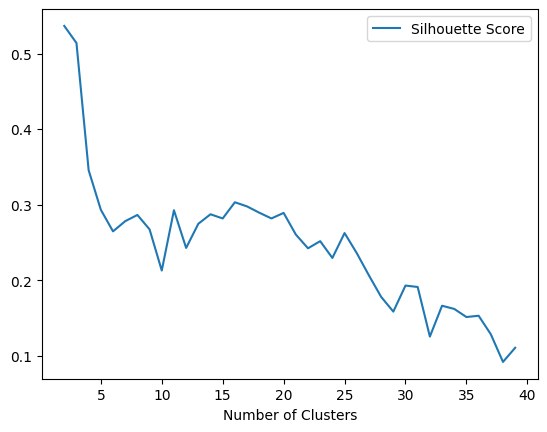

In [36]:
clusts=list(range(2,40))
clustNumb=pd.DataFrame(columns=['Number of Clusters','Silhouette Score'])
for cvi in clusts:
    clf = KMeans(n_clusters=cvi, random_state=42)
    clf.fit(data_filled)
    y_pred=list(clf.labels_)
    tempSill=pd.DataFrame({'Number of Clusters':[cvi],'Silhouette Score': [metrics.silhouette_score(data_filled, y_pred)]})
    clustNumb=pd.concat((clustNumb, tempSill), axis=0)
clustNumb['Number of Clusters'] = clustNumb['Number of Clusters'].astype(int)
clustNumb.set_index('Number of Clusters', inplace= True)
clustNumb.plot(y='Silhouette Score')
topclusts=list(clustNumb.sort_values(by='Silhouette Score', ascending=False).index[0:4])
clustNumb.sort_values(by='Silhouette Score', ascending=False)
#Number of Clusters Determination
# ClustPlot = clustNumb.plot(y='Silhouette Score', label = 'K-Means')

,Silhouette Score
Number of Clusters,
2,0.541393
5,0.34245
4,0.317031
3,0.310036
6,0.306645
8,0.281958
15,0.281552
9,0.275918
14,0.27511


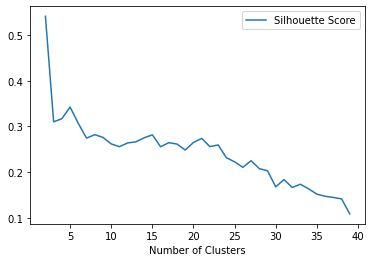

In [ ]:
clusts=list(range(2,40))
clustNumb=pd.DataFrame(columns=['Number of Clusters','Silhouette Score'])
for cvi in clusts:
    clf = KMeans(n_clusters=cvi, random_state=42)
    clf.fit(data_filled)
    y_pred=list(clf.labels_)
    tempSill=pd.DataFrame({'Number of Clusters':[cvi],'Silhouette Score': [metrics.silhouette_score(data_filled, y_pred)]})
    clustNumb=pd.concat((clustNumb, tempSill), axis=0)
clustNumb['Number of Clusters'] = clustNumb['Number of Clusters'].astype(int)
clustNumb.set_index('Number of Clusters', inplace= True)
clustNumb.plot(y='Silhouette Score')
topclusts=list(clustNumb.sort_values(by='Silhouette Score', ascending=False).index[0:4])
clustNumb.sort_values(by='Silhouette Score', ascending=False)
#Number of Clusters Determination
# ClustPlot = clustNumb.plot(y='Silhouette Score', label = 'K-Means')

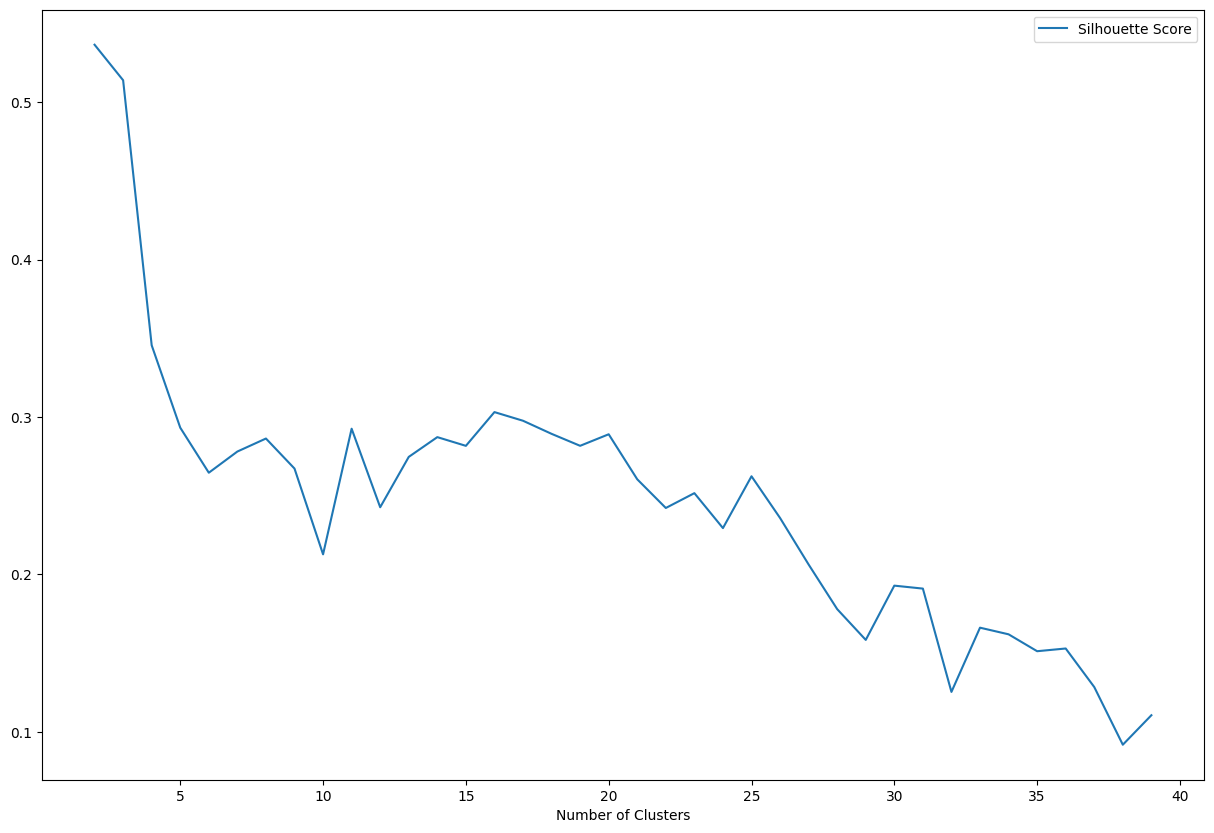

In [37]:
clustNumb.sort_values(by='Silhouette Score', ascending=False).to_csv('SillScore.csv')
temp=clustNumb.plot(y='Silhouette Score',figsize=(15,10))
temp.figure.savefig('SillCore.png')

In [40]:
topclusts=list(clustNumb.sort_values(by='Silhouette Score', ascending=False).index[0:4])
topclusts=[2,3,4,5]

In [38]:
#StudyAREA Shapefile
shpath = "StudyArea.shp" #Shapefile Path
shapFile = gpd.read_file(shpath)
shapFileFiltered=shapFile.to_crs("EPSG:4326")                    #Polygon

gdf = gpd.GeoDataFrame(latlong, geometry=gpd.points_from_xy(latlong.LONGITUDE, latlong.LATITUDE,crs="EPSG:4326"))  #Points

In [60]:
data_filled

,pH,TDS,Na+,K+,Cl-,SO42-,222Rn (Bq/L)
Sample_Name,,,,,,,
SP1,-0.054099,0.755631,0.761974,1.014379,0.684422,0.194329,0.313936
SP2,-0.203146,1.788559,1.718674,1.713361,1.670570,0.993801,-0.071717
SP3,-0.103781,0.835298,0.950877,0.804684,0.878129,0.173829,0.667452
SP4,-0.004416,2.066021,2.242725,1.888107,2.095957,0.891304,2.563582
SP5,1.982886,2.711601,2.858182,3.425868,2.501533,2.592745,-0.697440
SP6,2.032569,2.706107,2.613218,2.517191,2.598387,1.096297,-0.731828
SP7,0.956113,1.324291,1.621175,1.643463,1.554456,0.317324,3.045649
SP8,0.724261,1.316049,1.214121,1.573565,1.283705,0.173829,3.624130
SP9,1.469500,1.414947,1.353056,1.224074,1.438341,0.071333,-0.232406


Number of Clusters:  2
X:  45
y:  45
X2:  81
y2:  81
Drawing Accuracy:  1.0 


Number of Clusters:  3
X:  45
y:  45
X2:  81
y2:  81
Drawing Accuracy:  1.0 


Number of Clusters:  4
X:  45
y:  45
X2:  65
y2:  65
Drawing Accuracy:  1.0 


Number of Clusters:  5
X:  45
y:  45
X2:  61
y2:  61
Drawing Accuracy:  0.9333333333333333 




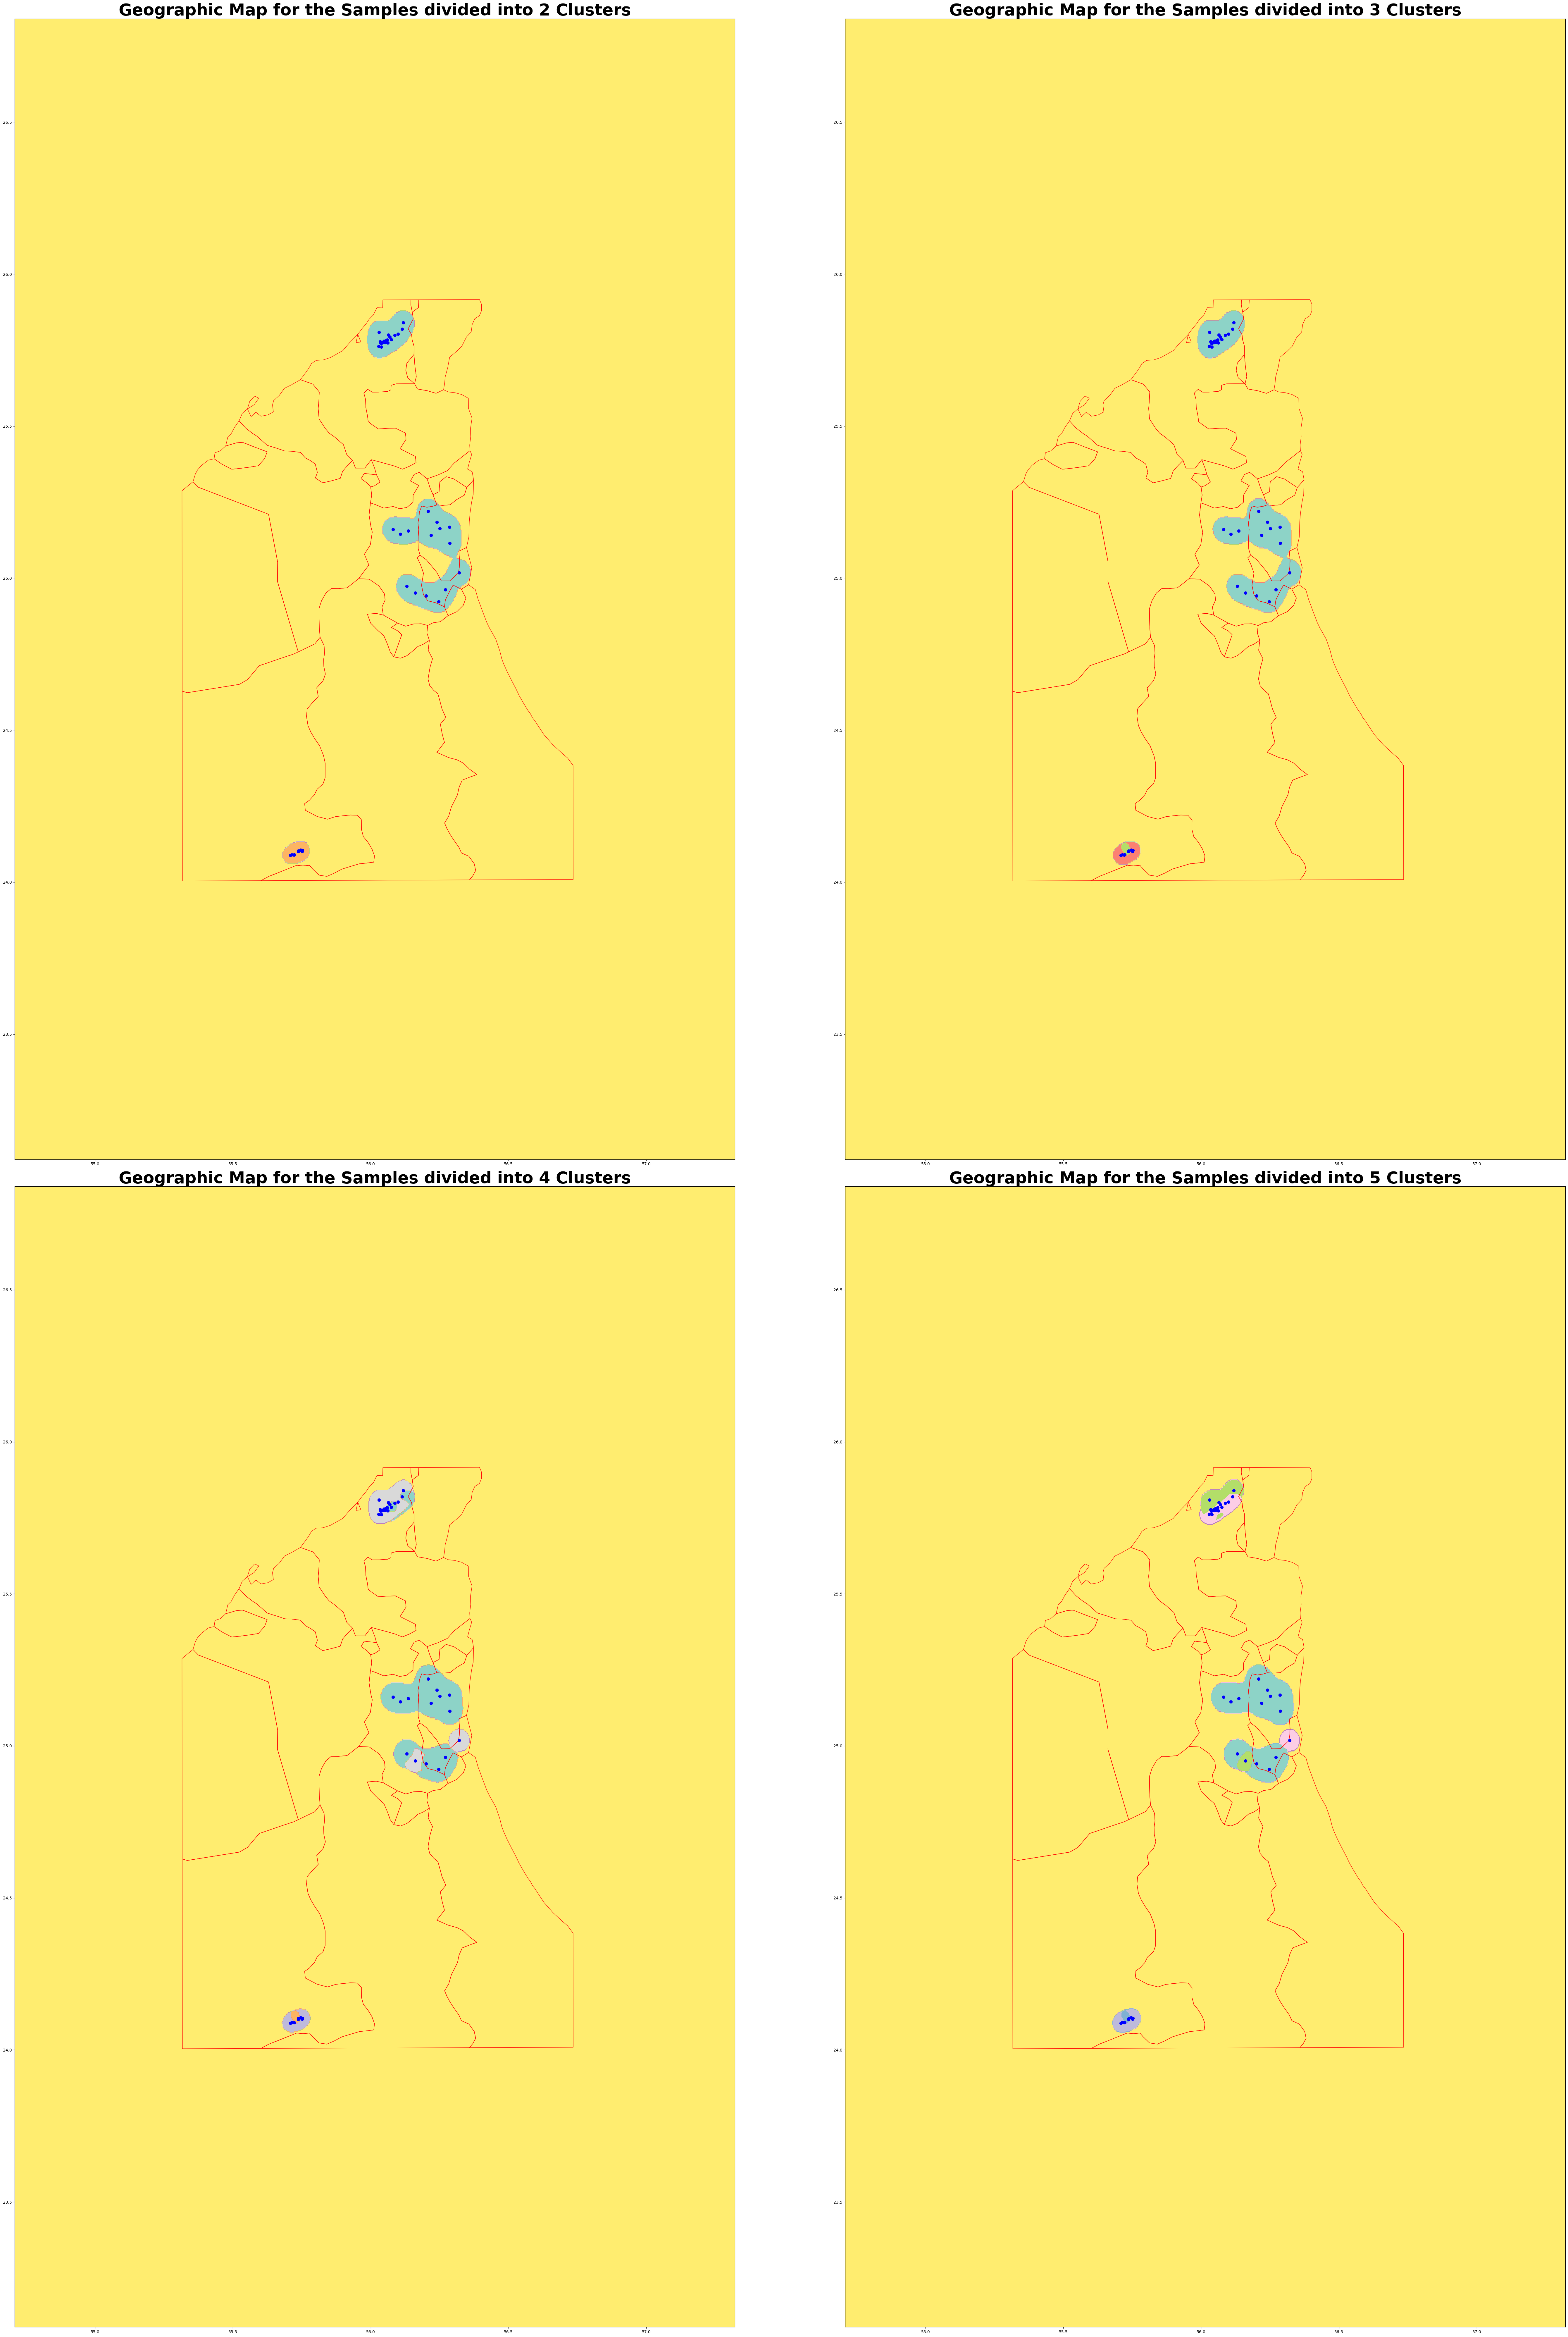

In [63]:
Clusters=topclusts

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(60,80))

#Finding the Most suitable Number of Expected Clusters
for clust in Clusters:
    clf = KMeans(n_clusters=clust, random_state=42)
    clf.fit(data_filled)
    y_pred=list(clf.labels_)
    indx=Clusters.index(clust)

    if indx == 0:
        i=0
        z=0
    elif indx==1:
        i=0
        z=1
    elif indx==2:
        i=1
        z=0
    elif indx==3:
        i=1
        z=1

    print('Number of Clusters: ',clust)
    #Clustered
    X=latlong[['LONGITUDE','LATITUDE']]
    print('X: ',len(X))
    y=copy.deepcopy(y_pred)
    print('y: ',len(y))
    X2,y2=bazel_cluster(X,y,  extent=1, random_seed=42)
    print('X2: ',len(X2))
    print('y2: ',len(y2))
    X=X.to_numpy()
    y=np.array(y)
    X2=X2.to_numpy()
    y2=np.array(y2)

    clf = SVC(C= 100, gamma= 700.0, random_state=42)
    clf.fit(X2, y2)
    print('Drawing Accuracy: ',clf.score(X, y), '\n\n')
    # clf.fit(X_train, y_train)
    # print(clf.score(X_test, y_test))
    cmap = mpl.colormaps['Set3']

    axes[i][z].set_title(f'Geographic Map for the Samples divided into {clust} Clusters',fontsize = 40, fontweight ="bold")

#     disp = plot_decision_regions(X, y, clf=clf, legend=0, ax=axes[i][z], cluster='ray')
    disp = DecisionBoundaryDisplay.from_estimator(clf, X, response_method='predict', ax=axes[i][z] ,grid_resolution=1000, plot_method='contourf', cmap=cmap)
    shapFileFiltered.plot( color='none', edgecolor='red', ax=axes[i][z])
    gdf.plot( marker='o',  color='blue', markersize=50, ax=axes[i][z])
fig.tight_layout()

In [46]:
fig.figure.savefig('ClustMap.png')

Total Number of Samples:
X:  45
y:  45

Bazel Function is: Enabled 
If the Bazel Cluster is visible, this indicates that the function has failed, try to modify the number of samples or the extent of the Bazel and run it again 

X with Bazel:  81
y with Bazel:  81

Drawing Accuracy:  100.0 %




,LONGITUDE,LATITUDE,pH,Temperature (C°),TDS,Na+,K+,Cl-,SO42-,222Rn (Bq/L),Elevation (m),Class
Sample_Name,,,,,,,,,,,,
SP1,373072,2665980.617,8.07,48.1,6300,1415,52.0,3021.000000,680.000000,35.00,290.157,3
SP2,372867,2666397.946,7.98,40.9,10060,2200,72.0,4813.000000,1070.000000,23.00,275.647,3
SP3,373147,2666355.028,8.04,44.6,6590,1570,46.0,3373.000000,670.000000,46.00,278.036,3
SP4,372579,2666539.936,8.10,34.3,11070,2630,77.0,5586.000000,1020.000000,105.00,266.671,2
SP5,371687,2666234.203,9.30,27.6,13420,3135,121.0,6323.000000,1850.000000,3.53,246.293,0
SP6,371614,2665954.685,9.33,28.5,13400,2934,95.0,6499.000000,1120.000000,2.46,245.826,0
SP7,370128,2664779.649,8.68,33.9,8370,2120,70.0,4602.000000,740.000000,120.00,224.888,2
SP8,369990,2664765.288,8.54,34.3,8340,1786,68.0,4110.000000,670.000000,138.00,219.393,2
SP9,368714,2664591.262,8.99,30.7,8700,1900,58.0,4391.000000,620.000000,18.00,210.892,3


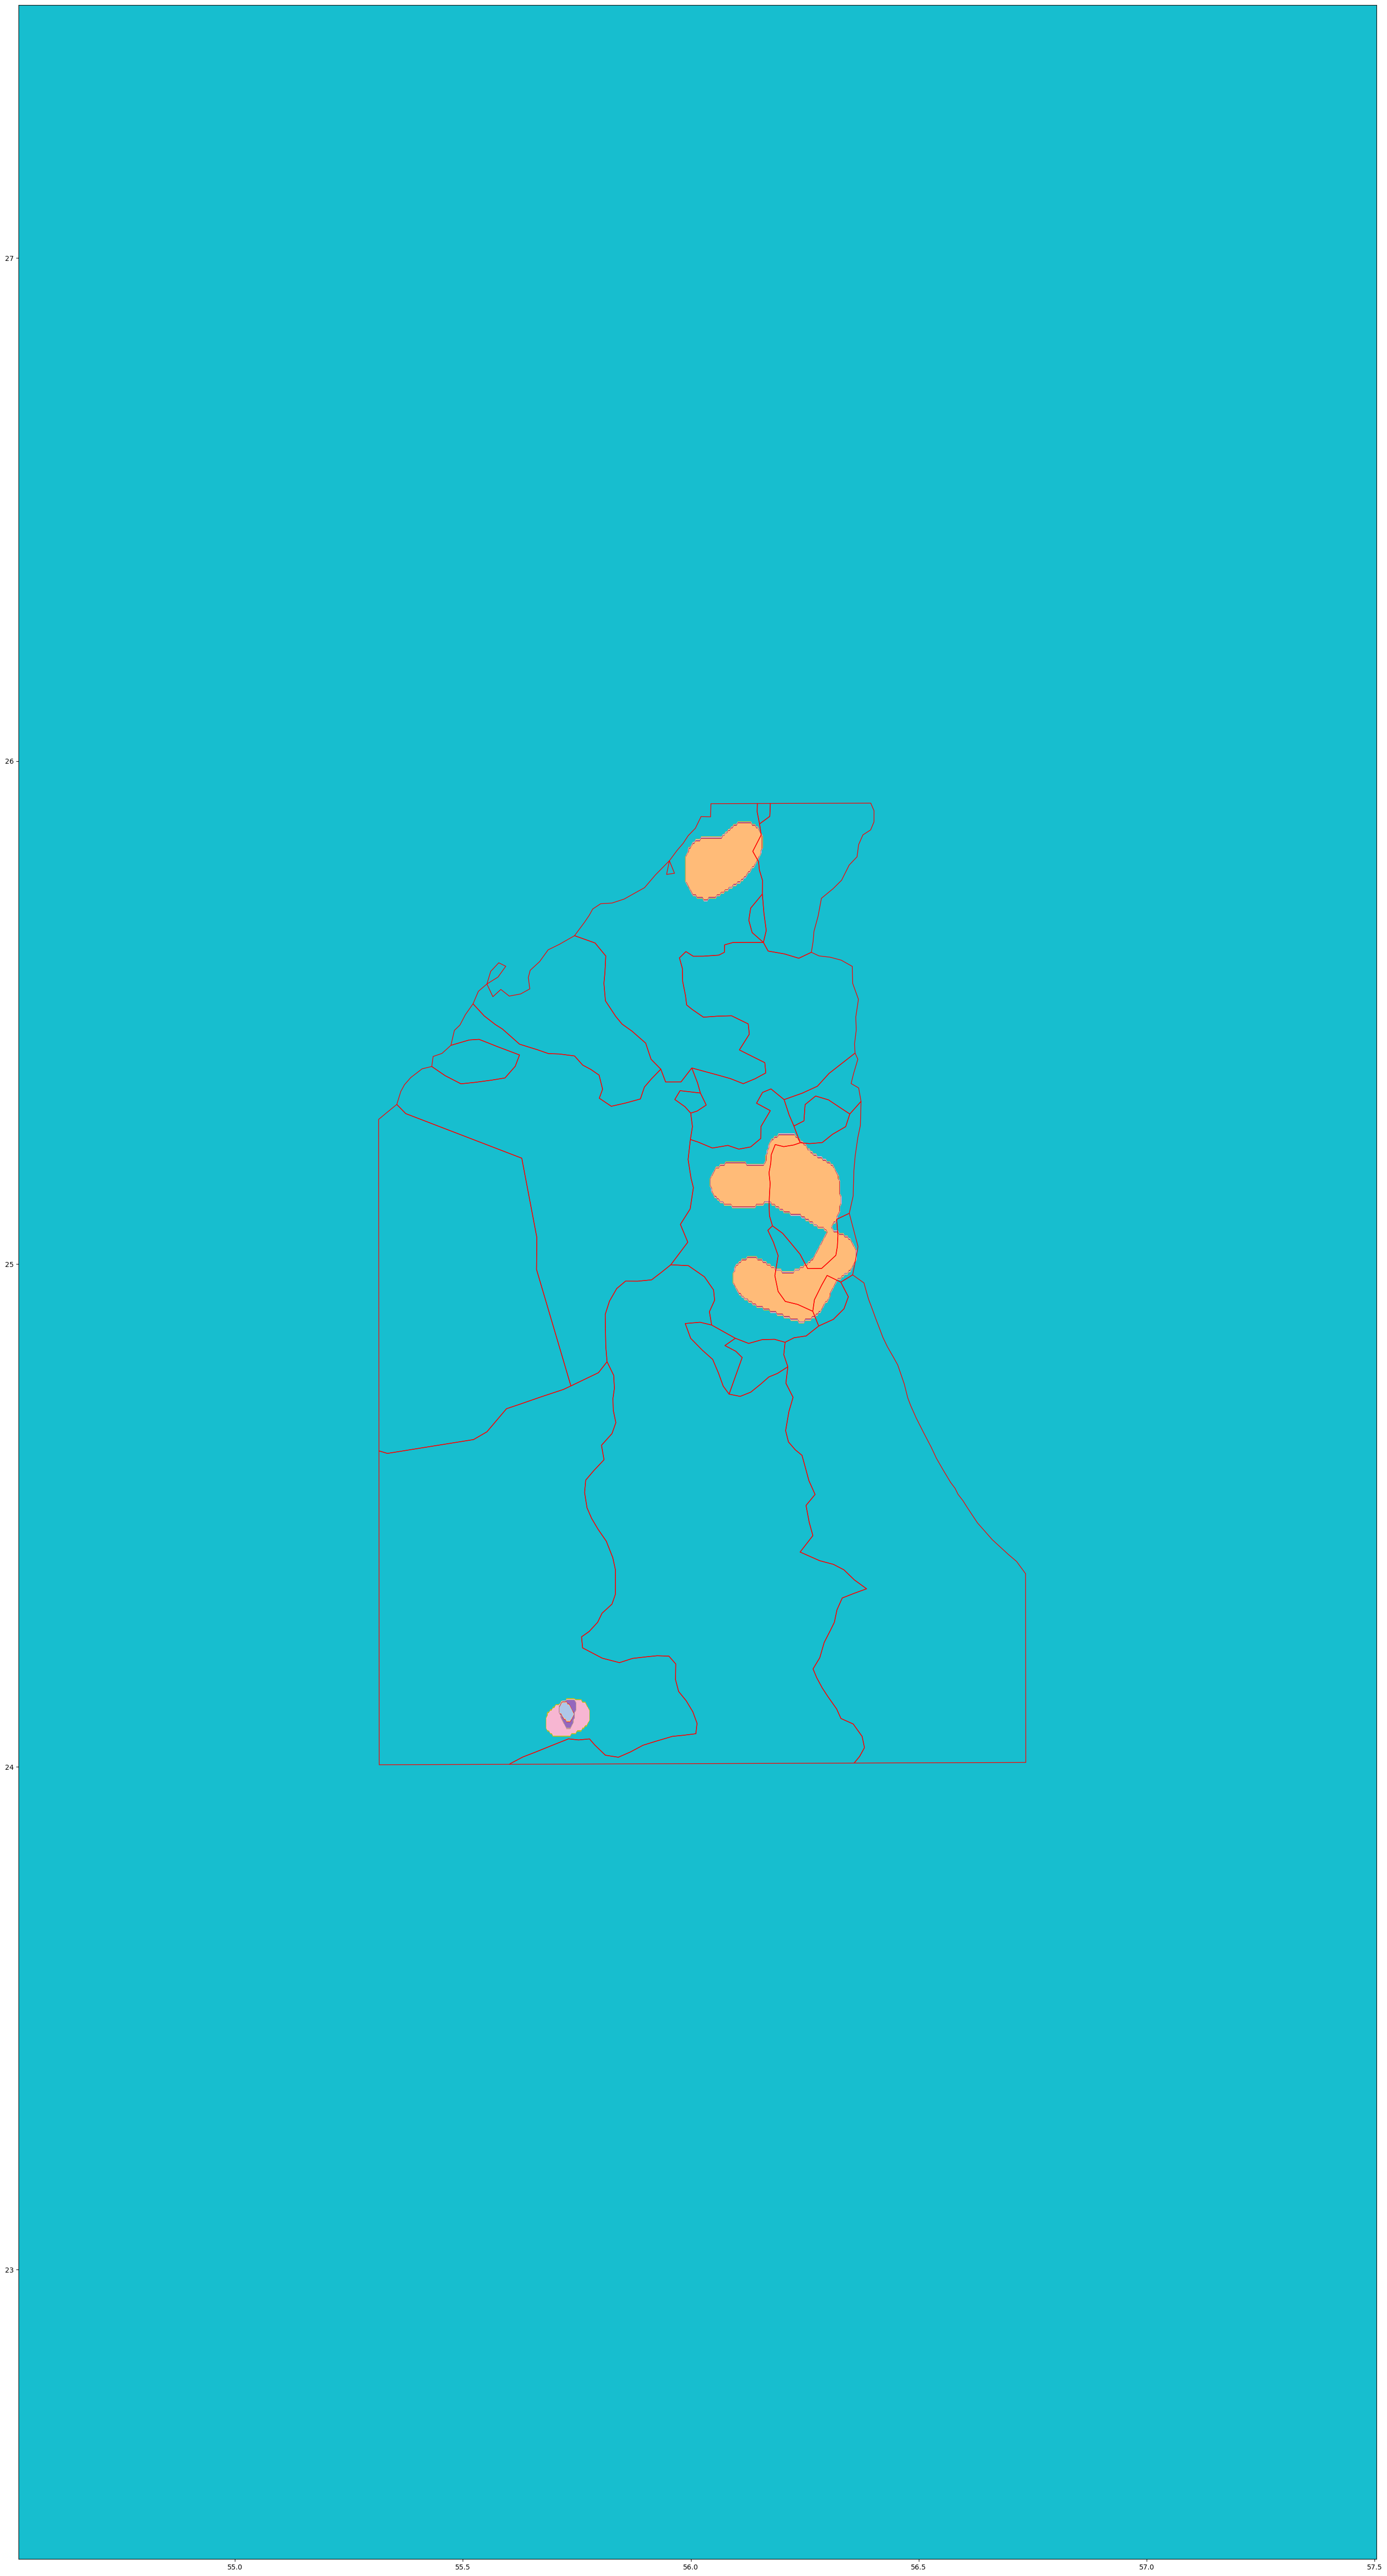

In [62]:
# clf = KMeans(n_clusters=topclusts[0])
clf = KMeans(n_clusters=4, random_state=42)
clf.fit(data_filled)
y_pred=pd.DataFrame(clf.labels_)

fig=geoz.sklearn_plot(latlong,y_pred, gamma=700.0, grid_resolution=1000, bazel=True, random_seed=42)
shapFileFiltered.plot(color='none', edgecolor='red',figsize=(10,20), ax=fig)
# geoz.mlx_plot(latlong,y_pred, bazel=True)
# fig.figure.savefig('test2.pdf')

# data.loc['R-KH18',['Cl-','SO42-']]=data_filled.loc['R-KH18',['Cl-','SO42-']]
data.loc['R-KH18',['Cl-','SO42-']]=scaler.inverse_transform([data_fill.loc['R-KH18'].values])[0][[5,6]]
data['Class']=clf.labels_
data.to_csv(f'ClassifiedData {4}.csv')
data

In [48]:
temp=shapFileFiltered.plot(color='none', edgecolor='red', ax=fig)
temp.figure.savefig('FinalMap.png')

In [55]:
surrogate_model = shap.KernelExplainer(clf.predict, data_filled)
shap_values = surrogate_model.shap_values(data_filled)

  0%|          | 0/45 [00:00<?, ?it/s]

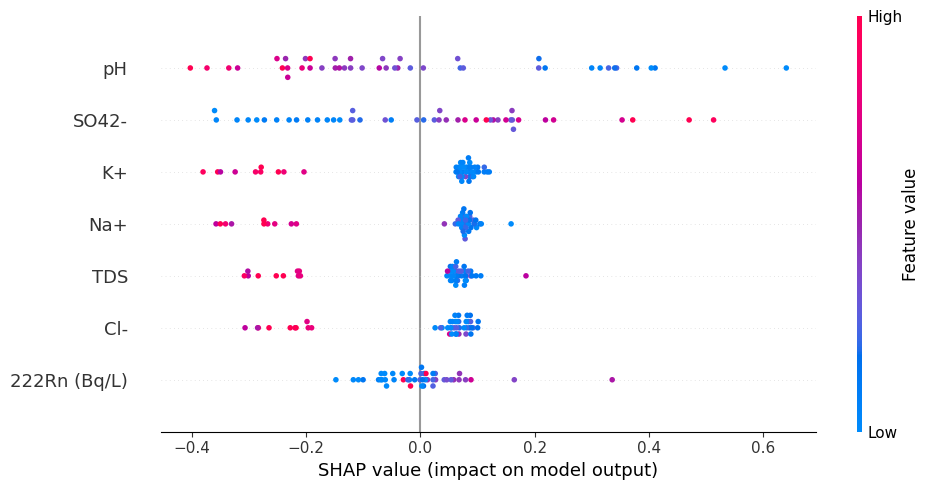

In [56]:
plott=shap.summary_plot(shap_values, data_filled,plot_size=(10,5),show=False)

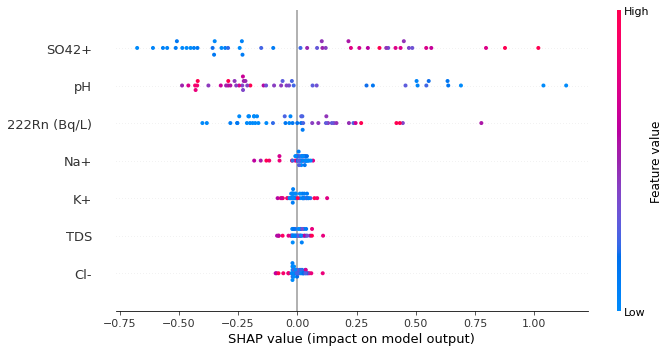

In [ ]:
plott=shap.summary_plot(shap_values, data_filled,plot_size=(10,5),show=False)

In [51]:
plt.savefig("summary_plot.png", dpi=300)

<Figure size 640x480 with 0 Axes>

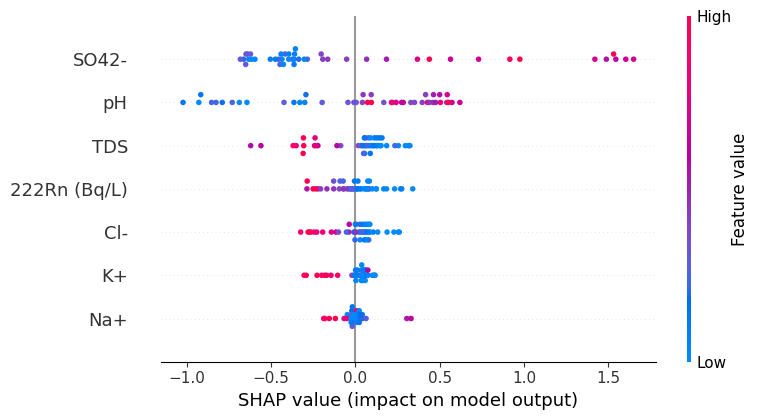

In [52]:
shap.summary_plot(shap_values, data_filled)